In [1]:
import copy
import collections
import functools
import os
import json

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import jacinle.random as random
import jacinle.io as io
import jactorch.nn as jacnn

from difflogic.cli import format_args
#from difflogic.dataset.graph import 
from data.toy_dataset import ToyDataset

from difflogic.myutils import update_dict_list
from difflogic.nn.neural_logic import LogicMachine, LogicInference
from difflogic.nn.neural_logic.modules._utils import meshgrid_exclude_self
from difflogic.thutils import binary_accuracy
from difflogic.train import TrainerBase
from difflogic.nn.dlm.layer import DifferentiableLogicMachine
from difflogic.nn.dlm.neural_logic import DLMInferenceBase

from jacinle.cli.argument import JacArgumentParser
from jacinle.logging import get_logger, set_output_file
from jacinle.utils.container import GView
from jacinle.utils.meter import GroupMeters
from jactorch.data.dataloader import JacDataLoader
from jactorch.optim.accum_grad import AccumGrad
from jactorch.optim.quickaccess import get_optimizer
from jactorch.train.env import TrainerEnv
from jactorch.utils.meta import as_cuda, as_numpy, as_tensor

from data.toy.game.header import *

from data.toy_dataset import ToyDataset
from torch_geometric.loader import DataLoader

pygame 2.6.1 (SDL 2.30.7, Python 3.9.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


<frozen importlib._bootstrap>:228: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


In [65]:
def pyg_to_pred_tensors(data):
    def convert_graph(data):
        nullary = torch.zeros(len(RELS))
        unary = data.x

        binary = torch.zeros(data.num_nodes, data.num_nodes, len(RELS))
        for i,type in enumerate(data.edge_type):
            binary[data.edge_index[0][i], data.edge_index[1][i], type] = 1
        
        tensors = [nullary, unary, binary]
        tensors = [tensor.unsqueeze(0) for tensor in tensors]

        return tensors

    if data.batch is not None:
        datalist = data.to_data_list()
        tensors_list = [convert_graph(d) for d in datalist]
        nullaries = torch.vstack([t[0] for t in tensors_list])
        unaries = torch.vstack([t[1] for t in tensors_list])
        binaries = torch.vstack([t[2] for t in tensors_list])
        return [nullaries, unaries, binaries]
    else:
        pred_tensors = convert_graph(data)
        return pred_tensors

    #pred_tensors = pyg_to_pred_tensors(trainset[1])

def show_pyg_graph(graph):

    # Create an empty NetworkX directed graph
    G = nx.DiGraph()
    
    # Add nodes with their features
    for i in range(graph.num_nodes):
        G.add_node(i, label=NODES[graph.node_type[i].item()])
    
    # Add edges with their attributes
    edge_index = graph.edge_index
    edge_type = graph.edge_type if 'edge_type' in graph else None
    for i in range(edge_index.size(1)):
        source, target = edge_index[:, i].tolist()
        if edge_type is not None:
            label = RELS[int(edge_type[i].item())]
            G.add_edge(source, target, label=label)
        else:
            G.add_edge(source, target)
    
    # Draw the graph
    pos = nx.circular_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, font_size=10, font_color='black', font_weight='bold', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

class NLMModel(nn.Module):
    def __init__(self, depth, breadth, input_dim, output_dim, hidden_dim=8):
        super(NLMModel, self).__init__()
        self.transform = pyg_to_pred_tensors
        self.nlm = LogicMachine(depth, breadth, input_dim, input_dim, hidden_dim)
        self.nlm_inf = LogicInference(input_dim, output_dim, hidden_dim)

    def forward(self, data):
        pred_tensors = self.transform(data)
        features = self.nlm(pred_tensors)[1]
        inferred = self.nlm_inf(features).squeeze()[0]
        return inferred


class DLMModel(nn.Module):
    def __init__(self, device, depth, breadth, input_dim, output_dim, dlm_intern_params=None, arity=1):
        super(DLMModel, self).__init__()
        self.device = device
        self.transform = pyg_to_pred_tensors
        self.arity = arity
        self.dlm = DifferentiableLogicMachine(
            depth, breadth, input_dim, input_dim, dlm_intern_params=dlm_intern_params)
        self.dlm_inf = DLMInferenceBase(input_dim, output_dim, False, 'root')

    def forward(self, data, extract=False):
        pred_tensors = self.transform(data)
        pred_tensors = [t.to(self.device) for t in pred_tensors]
        if extract:
            self.dlm.extract_graph(self.arity, self.dlm_inf)
        features, other_outputs = self.dlm(pred_tensors, extract_rule=extract)
        unary_features = features[self.arity]
        inf_outputs = self.dlm_inf(unary_features)
        if extract:
            print(self.dlm_inf.weight.argmax(-1))
        inferred = inf_outputs[0].squeeze()[0]
        return inferred

    def predict(self, data, threshold=0.5, extract=False):
        prob = self.forward(data, extract=extract)
        pred = (prob > threshold).int().squeeze()
        return pred


In [67]:
def train(model, loader, weight, device, target_predicate=0, epochs=1):
    print('weight:', weight)
    #criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.BCELoss()

    P = model.parameters()

    optimizer = torch.optim.Adam(P, lr=1e-2)

    model.train()
    for e in range(epochs):
        epoch_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)

            label = data.z[target_predicate]
            #print(out.detach().numpy(), label.numpy())
            print(round(out.detach().item()), label.item())
            loss = criterion(out, label.float())

            #print(loss.item())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print("Epoch %d" % e, epoch_loss / len(loader.dataset))

trainset = ToyDataset('data', mode='graph', split='train')
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

device = torch.device('cpu')
num_affd_classes = len(VERBS)

weight = len(trainset) / (num_affd_classes * trainset.verb_label_counts)
weight = torch.tensor(weight, dtype=torch.float).to(device)

#model = Model(4, 2, 8, num_affd_classes)
dlm_intern_params = {'atoms_per_rule': 2, 'fuzzy_or': True, 'add_negation': True}
model = DLMModel(device, 2, 2, len(RELS), 1, dlm_intern_params=dlm_intern_params)
model.to(device)

train(model, trainloader, weight, device, target_predicate=1, epochs=20)

weight: tensor([0.4527, 1.2108, 3.7864, 1.4264])
0 0
0 0
0 0
1 0
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 0
1 1
0 1
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
1 1
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 0
0 0
0 1
0 1
0 1
0 0
0 0
1 1
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
1 0
0 1
0 0
0 0
1 1
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
1 1
0 1
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
1 0
0 1
0 1
0 1
0 1
1 0
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
1 0
0 0
0 1
0 0
0 0
0 0
0 0
1 0
0 0
0 1
0 0
0 1
0 1
0 0
0 0

In [43]:
print(len(NODES) + 2 * len(RELS))

33


In [52]:
predicates = [[]] * len(RELS) + NODES + RELS
map = [(i,pred) for i,pred in enumerate(predicates)]
for m in map:
    print(m)

(0, [])
(1, [])
(2, [])
(3, [])
(4, [])
(5, [])
(6, [])
(7, [])
(8, [])
(9, [])
(10, [])
(11, 'move to')
(12, 'grab')
(13, 'cut')
(14, 'put down')
(15, 'player')
(16, 'empty square')
(17, 'wall')
(18, 'knife')
(19, 'tomato')
(20, 'whole')
(21, 'sliced')
(22, 'direct obj')
(23, 'verb')
(24, 'with')
(25, 'is')
(26, 'afford')
(27, 'holding')
(28, 'on top of')
(29, 'up of')
(30, 'down from')
(31, 'left of')
(32, 'right of')


Testing DLM model======================
Threshold: 0.5
layer 0
breadth 0
{np.int64(25), np.int64(27)}
tensor([[-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [25, 27],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1]])
predicate 25
Exists predicate 7 for breadth 1
permute (0,)
predicate 27
Exists predicate 8 for breadth 1
permute (0,)
breadth 1
{np.int64(40), np.int64(24), np.int64(32)}
tensor([[-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [40, 32],
        [-1, -1],
        [24, 32],
        [-1, -1],
        [-1, -1]])
predicate 40
Exists predicate 9 for breadth 2
permute (0, 1)
predicate 24
Exists predicate 1 for breadth 2
permute (0, 1)
predicate 32
Exists predicate 5 for breadth 2
permute (0, 1)
breadth 2
{np.int64(0), np.int64(16)}
tensor([[-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],
        [-1, -1],


(array([0]), array([0]))

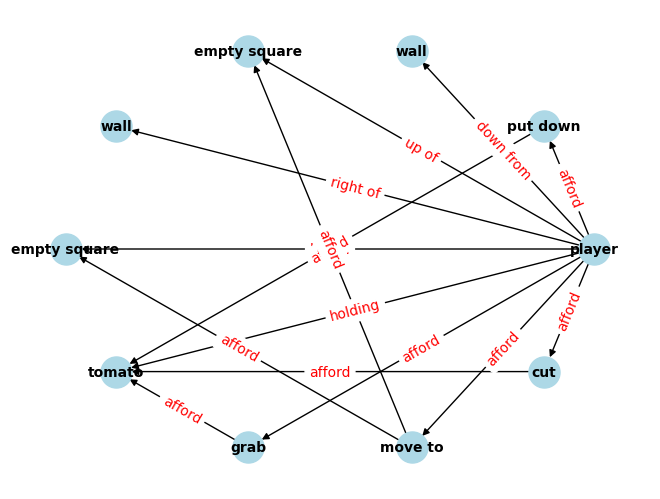

In [72]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score

def metrics(y_true, y_pred):
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    # Print the confusion matrix for each label
    for i, cm in enumerate(mcm):
        tn, fp, fn, tp = cm.ravel()
        print(f"Label {i}: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"Accuracy: {accuracy}")
    print(f"Mean Avg Precision: {precision}")
    print(f"Mean Avg Recall: {recall}")

def test(model, loader, device, target_predicate=0, threshold=0.5, extract=False):
    print('Testing DLM model======================')
    print('Threshold:', threshold)
    preds, labels = [], []
    for i,data in enumerate(loader):
        data = data.to_data_list()[0]
        show_pyg_graph(data)
        data = data.to(device)
        mask = None
        pred = model.predict(data, threshold, extract=extract).cpu()

        label = data.z[target_predicate].cpu()
        print(pred.item(), label.item())
        preds.append(pred.item())
        labels.append(label.item())

    preds = np.stack(preds)
    labels = np.stack(labels)
    print(np.bincount(labels))
    metrics(labels, preds)
    return preds, labels

testset = ToyDataset('data', mode='graph', split='test')
testloader = DataLoader(testset[:1], shuffle=False)

test(model, testloader, device, target_predicate=1, extract=True)


In [16]:
w = torch.zeros(3, 3)
m = w.argmax(-1)
print(w, m)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]) tensor([0, 0, 0])
